In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

from nltk.stem.snowball import SnowballStemmer

In [3]:
Base = declarative_base()

In [4]:
class Recipe(Base):
    __tablename__ = 'recipes'
    
    id = Column(Integer, primary_key=True)
    name = Column(String)
    url = Column(String, unique=True)
    calories = Column(Integer)
    fat = Column(Float)
    carbs = Column(Float)
    protein = Column(Float)
    cholesterol = Column(Float)
    sodium = Column(Float)
    servings = Column(Integer)
    #ingredients = 
    #__table_args__ = {'extend_existing': True}
    
    def __repr__(self):
        return "<Recipe(name='%s', url='%s')>" % (
            self.name, self.url)
    
class Ingredient(Base):
    __tablename__ = 'ingredients'
    id = Column(Integer, primary_key = True)
    ingredient = Column(String, nullable = False)
    recipe_id = Column(Integer, ForeignKey('recipes.id'))
    
    recipe = relationship(Recipe, back_populates = 'ingredients')
    #__table_args__ = {'extend_existing': True}
    def __repr__(self):
        return "<Ingredient(ingredient='%s')>" % self.ingredient

Recipe.ingredients = relationship("Ingredient", order_by=Ingredient.id, back_populates="recipe")

class Restaurant(Base):
    __tablename__ = 'restaurants'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    url = Column(String)
    zomatoID = Column(Integer, unique=True)
    costfortwo = Column(Float)
    featured_image = Column(String)
    photos = Column(String)
    menu_url = Column(String)
    price_range = Column(Integer)
    latitude = Column(Float)
    longitude = Column(Float)
    address = Column(String)
    
    def __repr__(self):
        return "<Restaurant(name='%s', url='%s')>" % (
            self.name, self.url)

class MenuItem(Base):
    __tablename__ = 'menuitems'
    id = Column(Integer, primary_key=True)
    menuitem = Column(String, nullable = False)
    description = Column(String)
    restaurant_id = Column(Integer, ForeignKey('restaurants.id'))
    price = Column(String)
    
    restaurant = relationship(Restaurant, back_populates = 'menuitems')
    __table_args__ = {'extend_existing': True}
    def __repr__(self):
        return "<MenuItem(item='%s', desc='%s')>" % (
            self.menuitem, self.description)
    
Restaurant.menuitems = relationship("MenuItem", order_by=MenuItem.id, back_populates="restaurant")

In [5]:
measurements = ("femtogram", "gigagram", "gram", "hectogram", "kilogram", \
                "long", "ton", "mcg", "megagram", "metric", "ton", "metric"\
                "tonne", "microgram", "milligram","nanogram", "ounce", \
                "lb", "oz", "each", "pound", "short", "Gram", "Ounce", "Pint", "Quart",\
                "Tablespoon", "Teaspoon", "Tablespoons", "Teaspoons", "Cups", "cup","Fluid Ounce", "fl oz", "Gallon", "Ounce", \
                "Pint", "Quart", "Tablespoon", "Teaspoon", "liter", "litre", "L", "ml", "fluid ounces", "can", "cans")

In [6]:
def find_measurement_words(i):
    ingredient_line = i
    for item in measurements:
        meas = str(" " + item.lower() + " ")
        a = re.search(meas, ingredient_line)
        if a > 0:
            unit = ingredient_line[a.start():a.end()].strip()
            quantity = ingredient_line[:a.start()].strip()
            ingredient = ingredient_line[a.end():].strip()
            break
        else:
            ilist = i.split(" ")
            quantity = ilist[0]
            unit = "each"
            ingredient = " ".join(ilist[1:])
    newitem = {"ingredient": ingredient,
    "unit": unit,
    "quantity":  quantity}
    try:
        fracsplit = ([float(k) for k in newitem["quantity"].split("/")])
        if len(fracsplit) >= 2:
            newitem["quantity"] = fracsplit[0] / fracsplit[1]
    except:
        None
    #print(newitem)
    return newitem

In [7]:
def clean_up_ingredient(ingredient_line):
    ingredient_line = re.sub("\[u\'", "", ingredient_line)
    ingredient_line = re.sub("\']", "", ingredient_line)
    return find_measurement_words(ingredient_line)

In [8]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://andylane@localhost/restaurants


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sqlalchemy/dialects/__init__.py:34: SADeprecationWarning: The SQLAlchemy PostgreSQL dialect has been renamed from 'postgres' to 'postgresql'. The new URL format is postgresql[+driver]://<user>:<pass>@<host>/<dbname>
  module = __import__('sqlalchemy.dialects.%s' % (dialect, )).dialects


In [9]:
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

##Get recipe names into a vector

In [10]:
names = session.query(Recipe).all()

In [11]:
titles=[]
for item in names:
    titles.append(item.name)

##Get ingredient lists into vector, order matching names

In [12]:
synopses = []
for item in names:
    synopses.append(" ".join([clean_up_ingredient(a.ingredient)["ingredient"] for a in item.ingredients]))

In [13]:
calories=[]
for item in names:
    calories.append(item.calories)

In [14]:
cholesterol=[]
for item in names:
    cholesterol.append(item.cholesterol)

http://brandonrose.org/clustering

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

## Match menu items to a cluster

In [16]:
def tokenize_and_stem(title):
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return [i for i in stemmed_titles]

In [17]:
nltk.word_tokenize("braised short ribs")

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self)

['braised', 'short', 'ribs']

In [18]:
def cluster_recipes(titles, num_clusters = 380): 
    def tokenize_and_stem(title):
        stemmed_titles = []
        new_title=[]
        for word in nltk.word_tokenize(title):
            new_title.append(stemmer.stem(word))
        stemmed_titles.extend(new_title)
        return [i for i in stemmed_titles]

    def tokenize_only(title):
        tokenized_titles = []
        new_title=[]
        for word in nltk.word_tokenize(title):
            new_title.append(word)
        tokenized_titles.extend(new_title)
        return [i for i in tokenized_titles]

    #not super pythonic, no, not at all.
    #use extend so it's a big flat list of vocab
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in titles:
        totalvocab_stemmed.extend([j for j in tokenize_and_stem(i)])
        totalvocab_tokenized.extend([k for k in tokenize_only(i)])

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

    #define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                     min_df=0.01, stop_words='english',
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    count_vectorizer = CountVectorizer(max_df=0.9, max_features=200000,
                                     min_df=0.01, stop_words='english', tokenizer=tokenize_and_stem, ngram_range=(1,3))


    tfidf_matrix = tfidf_vectorizer.fit_transform(titles) #fit the vectorizer to synopses

    print(tfidf_matrix.shape)

    terms = tfidf_vectorizer.get_feature_names()

    from sklearn.metrics.pairwise import cosine_similarity
    dist = 1 - cosine_similarity(tfidf_matrix)

    from sklearn.cluster import KMeans
    #num_clusters = 380
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    from sklearn.externals import joblib
    #uncomment the below to save your model 
    #since I've already run my model I am loading from the pickle
    #joblib.dump(km,  'doc_cluster.pkl')
    #km = joblib.load('doc_cluster.pkl')
    recipes = {'title': titles, 'synopsis': synopses,'calories': calories,'cholesterol': cholesterol, 'cluster': clusters}
    frame = pd.DataFrame(recipes, index = [clusters] , columns = ['title', 'cluster', 'calories', 'cholesterol'])
    frame['cluster'].value_counts()
    grouped = frame['cholesterol'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
    grouped.mean() #average rank (1 to 100) per cluster
    return {"cluster_designations": frame, "vectorizer": tfidf_vectorizer, "model": km}

## Assign description to a cluster

In [19]:
def cluster_ingredients(synopses, num_clusters = 100):
    '''
    Input: a list containing space-separated ingredients for a set of recipes.
    Output: a scikit-learn k-means model object 
    '''
    
    # here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
    def tokenize_and_stem(text):
        # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
        tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems


    def tokenize_only(text):
        # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
        tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        return filtered_tokens

    #not super pythonic, no, not at all.
    #use extend so it's a big flat list of vocab
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in synopses:
        allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
    print(vocab_frame.head())

    from sklearn.feature_extraction.text import TfidfVectorizer

    #define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                     min_df=0.2, stop_words='english',
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

    print(tfidf_matrix.shape)
    terms = tfidf_vectorizer.get_feature_names()

    from sklearn.metrics.pairwise import cosine_similarity
    dist = 1 - cosine_similarity(tfidf_matrix)

    from sklearn.cluster import KMeans
    #num_clusters = 100
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    from sklearn.externals import joblib
    #uncomment the below to save your model 
    #since I've already run my model I am loading from the pickle
    #joblib.dump(km,  'doc_cluster.pkl')
    #km = joblib.load('doc_cluster.pkl')
    recipes = {'title': titles, 'synopsis': synopses,'calories': calories, 'cholesterol':cholesterol, 'cluster': clusters}
    frame = pd.DataFrame(recipes, index = [clusters] , columns = ['title', 'cluster', 'calories', 'cholesterol'])
    frame['cluster'].value_counts()
    grouped = frame['cholesterol'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
    grouped.mean() #average rank (1 to 100) per cluster
    return {"cluster_designations": frame, "vectorizer": tfidf_vectorizer, "model": km}

In [20]:
recipe_clusters = cluster_recipes(titles)

(3941, 96)


In [21]:
ingredient_clusters = cluster_ingredients(synopses)

there are 117798 items in vocab_frame
                  words
milk               milk
white             white
vinegar         vinegar
all-purpos  all-purpose
flour             flour
(3941, 36)


In [60]:
X_new = recipe_clusters['vectorizer'].transform(["salad"])
prediction = recipe_clusters['model'].predict(X_new)

In [61]:
# Predicts the cluster that a list of ingredients is in.
prediction

array([272], dtype=int32)

In [62]:
a = recipe_clusters["cluster_designations"].ix[prediction[0]]

In [54]:
np.mean(recipe_clusters["cluster_designations"].ix[prediction[0]]["cholesterol"])

74.83333333333333

In [ ]:
ingredient_clusters

In [ ]:
def classify_menu_item(menu_item, menu_item_description, recipe_clusters, ingredient_clusters):
    menu_item = " ".join(tokenize_and_stem(menu_item))
    vectorized_menu_item = recipe_clusters["vectorizer"].transform([menu_item]) #can later pass a list of menu_items
    recipe_cluster = recipe_clusters["model"].predict(vectorized_menu_item)
    print(recipe_cluster)
    description = " ".join(tokenize_and_stem(menu_item_description))
    #look up ingredient clusters list; return found ingredient clusters matching recipes
    # assign menu item description to an ingredient cluster
    # ask if there's a match 
    # for any 
    for item in recipe_cluster:
        print(item[1])
        recipeid = session.query(Recipe).filter(Recipe.name == item[1]).all()[0]
        
        #print session.query(Ingredient).filteritem[1]
    
    
    
    
    
    return recipe_clusters["cluster_designations"].ix[recipe_cluster]['title']

In [ ]:
recipe_clusters[110].transform([menu_item])

In [ ]:
classify_menu_item("Chicken pad thai", "", recipe_clusters, ingredient_clusters)

In [ ]:
for 

In [ ]:
menu_items = session.query(MenuItem).filter(MenuItem.restaurant_id == 82).all()

In [ ]:
[item.menuitem.encode("utf-8") for item in session.query(MenuItem).filter(MenuItem.restaurant_id == 9).all()]

In [ ]:
item for item in 

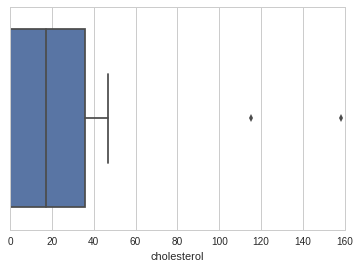

In [66]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=a["cholesterol"])
